In [ ]:
!pip install transformers

In [ ]:
# --> for cleaning:
!pip install langdetect

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizerFast, AutoModel,AdamW
from google.cloud import bigquery
from langdetect import detect
from google.colab import auth,drive
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.model_selection import train_test_split

# specify GPU
device = torch.device("cuda")

In [4]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
auth.authenticate_user()

In [6]:
project_id = 'tlac-vision'

client = bigquery.Client(project=project_id)
df = client.query('''
  SELECT
    *
  FROM
    `tlac-vision.book_backend.train_categories`
''').to_dataframe()

In [7]:
# --> sorting dataframe by book category, from A to Z
df = df.sort_values(['category'], ascending=True)

# --> dropping duplicate rows
df = df.drop_duplicates(['title']).reset_index(drop=True)

In [8]:
# --> deleting results that are in other languages different to spanish
df['language'] = ""
for index, row in df.iterrows():
    row['language'] = detect(row['description'])
df = df[df.language == 'es']

print(df.iloc[:,0:2].groupby('category').count().rename(columns={'title': 'count'})  # total of registers per category)


#Old data splitting

In [9]:
# --> 75% of data is for training
cat_count['training'] = round(0.75 * cat_count['count'], 0)

# --> organizing indexes to split data
cat_count['acum'] = cat_count['count'].cumsum()
cat_count['init_idx'] = cat_count['acum'] - cat_count['count']
cat_count['train_idx'] = cat_count['init_idx'] + cat_count['training']

In [10]:
# --> creating training set with 75% of data per category
train_set = pd.DataFrame(data=None, columns=df.columns)
for i in range(len(cat_count)):
    i_idx = int(cat_count.iloc[i, 3])
    f_idx = int(cat_count.iloc[i, 4])
    train_set = train_set.append(df.iloc[i_idx:f_idx, :])

train_set_f = train_set.loc[:, ['category', 'description']]
train_set_f=train_set_f.reset_index(drop=True)
#train_set_f['is_valid']=False
train_set_f.iloc[0:5,]

,category,description
0,anthropology,"""Después de 60 años como misionero en el Perú ..."
1,anthropology,A lo largo de los últimos cien años la antropo...
2,anthropology,"En este libro, uno de los principales teoricos..."
3,anthropology,"El fuego, presente ya en los inicios del proce..."
4,anthropology,Este ambicioso tratado sobre el fenómeno relig...


In [11]:
# --> creating validation set with 25% of data per category
val_set = pd.DataFrame(data=None, columns=df.columns)
for i in range(len(cat_count)):
    i_idx = int(cat_count.iloc[i, 4])
    f_idx = int(cat_count.iloc[i, 2])
    val_set = val_set.append(df.iloc[i_idx:f_idx, :])

val_set_f = val_set.loc[:, ['category', 'description']]
val_set_f=val_set_f.reset_index(drop=True)
#val_set_f['is_valid']=True
val_set_f.iloc[0:5,]

,category,description
0,anthropology,Antología preparada en torno al axolote (o axó...
1,anthropology,Sirviéndose de los recursos metodológicos prop...
2,anthropology,Este trabajo consta de dos partes bien diferen...
3,anthropology,"Los problemas de la bioética no solo son, en l..."
4,anthropology,"La ANTROPOLOGÍA kantiana, más que en la divers..."


In [12]:
id_label = dict(zip(train_set_f['category'].unique(), range(0,11))) #categorical labels to numerical
train_labels,train_text= train_set_f['category'].map(id_label),train_set_f['description']
val_labels,val_text= val_set_f['category'].map(id_label),val_set_f['description']

#new data splitting

#importing model and tokenizer

In [13]:
tokenizer = BertTokenizerFast.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")
bert_es = AutoModel.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased") #pretrained model

In [17]:
# --> sample data for BETO
text = ["esta es una prueba","estoy haciendo una prueba"]
sent_id = tokenizer.batch_encode_plus(text, padding=True) # encode text
print(sent_id)

{'input_ids': [[4, 1149, 1028, 1091, 3610, 5], [4, 1435, 2194, 1091, 3610, 5]], 'token_type_ids': [[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]}


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f92cfbb8fd0>]],
      dtype=object)

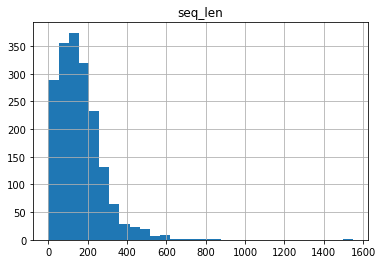

In [14]:
# --> distribution of the sequence lengths(number of words) in the train set to find the padding length 
seq_len = pd.DataFrame([len(i.split()) for i in train_set_f['description']],columns=['seq_len'])
seq_len.hist(bins = 30)

In [15]:
def intervals():
  to_return=list()
  j=0
  for i in range(0,32):
    to_return.append(j)
    j+=50

  return to_return
    
ranges = intervals()

sl_grouped=seq_len.groupby(pd.cut(seq_len.seq_len, ranges)).count().rename(columns={'seq_len':''})
sl_grouped=sl_grouped.add_suffix('count').reset_index()
sl_grouped['%']=round(100*sl_grouped['count'].cumsum()/sl_grouped['count'].sum(),3)

sl_grouped.iloc[0:10,:] 

,seq_len,count,%
0,"(0, 50]",270,14.501
1,"(50, 100]",350,33.298
2,"(100, 150]",357,52.470
3,"(150, 200]",315,69.388
4,"(200, 250]",244,82.492
5,"(250, 300]",149,90.494
6,"(300, 350]",68,94.146
7,"(350, 400]",36,96.079
8,"(400, 450]",24,97.368
9,"(450, 500]",24,98.657


#edit for test



In [16]:
# --> tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 250,
    padding='max_length',
    truncation=True
)

# --> tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 250,
    padding='max_length',
    truncation=True
)

In [18]:
# --> convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

#data loaders and model architecture

In [19]:
#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data
train_sampler = RandomSampler(train_data)
val_sampler = SequentialSampler(val_data)

# dataLoaders
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [20]:
#  --> freeze all the layers of the model before fine-tuning it

for param in bert_es.parameters():
    param.requires_grad = False

In [21]:
# --> model architecture

class BERT_Arch(nn.Module):

    def __init__(self, bert_es):
      
      super(BERT_Arch, self).__init__()
      self.bert_es = bert_es 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,11)  ####last layer equal to number of classes
      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):
      #pass the inputs to the model  
      _, cls_hs = self.bert_es(sent_id, attention_mask=mask)
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [22]:
# --> pass the pre-trained BERT in spanish to architecture
model = BERT_Arch(bert_es)

model = model.to(device) # push the model to GPU

optimizer = AdamW(model.parameters(), lr = 1e-5) # define the optimizer

#compute class weights for the labels in the train set and then pass these weights to the loss function so that it takes care of the class imbalance
class_weights = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print("Class Weights:",class_weights)

Class Weights: [2.22727273 0.84215287 1.80077369 0.82171227 0.80991736 0.98989899
 0.86806527 0.87706076 0.87253983 0.95634309 1.15940224]


In [23]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

weights = weights.to(device) # push to GPU

cross_entropy  = nn.NLLLoss(weight=weights) # define the loss function

epochs = 10 # number of training epochs

# Finetuning

In [24]:
# function to train the model
def train():
  
  model.train()
  total_loss, total_accuracy = 0, 0
  total_preds=[]   # empty list to save model predictions
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):

    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    batch = [r.to(device) for r in batch]  # push the batch to gpu

    sent_id, mask, labels = batch

    model.zero_grad() #clear previously calculated gradients 

    preds = model(sent_id, mask) # get model predictions for the current batch

    loss = cross_entropy(preds, labels) #compute the loss between actual and predicted values

    total_loss = total_loss + loss.item() # add on to the total loss

    loss.backward() # backward pass to calculate the gradients

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem

    optimizer.step() # update parameters

    preds=preds.detach().cpu().numpy() # model predictions are stored on GPU. it is necessary to push it to CPU

    total_preds.append(preds) # append the model predictions

  avg_loss = total_loss / len(train_dataloader) # compute the training loss of the epoch
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [25]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  model.eval() # deactivate dropout layers
  total_loss, total_accuracy = 0, 0
  total_preds = [] # empty list to save the model predictions

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      elapsed = format_time(time.time() - t0) # Calculate elapsed time in minutes.
            
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader))) # Report progress.

    batch = [t.to(device) for t in batch] # push the batch to gpu

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      preds = model(sent_id, mask) # model predictions
      loss = cross_entropy(preds,labels) # compute the validation loss between actual and predicted values
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [27]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    train_loss, _ = train()
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of     59.

Evaluating...

Training Loss: 2.344
Validation Loss: 2.342

 Epoch 2 / 10
  Batch    50  of     59.

Evaluating...

Training Loss: 2.325
Validation Loss: 2.321

 Epoch 3 / 10
  Batch    50  of     59.

Evaluating...

Training Loss: 2.305
Validation Loss: 2.301

 Epoch 4 / 10
  Batch    50  of     59.

Evaluating...

Training Loss: 2.282
Validation Loss: 2.284

 Epoch 5 / 10
  Batch    50  of     59.

Evaluating...

Training Loss: 2.260
Validation Loss: 2.266

 Epoch 6 / 10
  Batch    50  of     59.

Evaluating...

Training Loss: 2.243
Validation Loss: 2.250

 Epoch 7 / 10
  Batch    50  of     59.

Evaluating...

Training Loss: 2.220
Validation Loss: 2.232

 Epoch 8 / 10
  Batch    50  of     59.

Evaluating...

Training Loss: 2.203
Validation Loss: 2.214

 Epoch 9 / 10
  Batch    50  of     59.

Evaluating...

Training Loss: 2.180
Validation Loss: 2.198

 Epoch 10 / 10
  Batch    50  of     59.

Evaluating...

Training Loss: 2.167
Validation L

# Predictions

In [28]:
#load_weights_of_best_model

path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
#get_predictions_for_test_data

with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [ ]:
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))